C:\Users\abhay\AppData\Local\Temp\ipykernel_41300\1450123205.py:107: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab20')


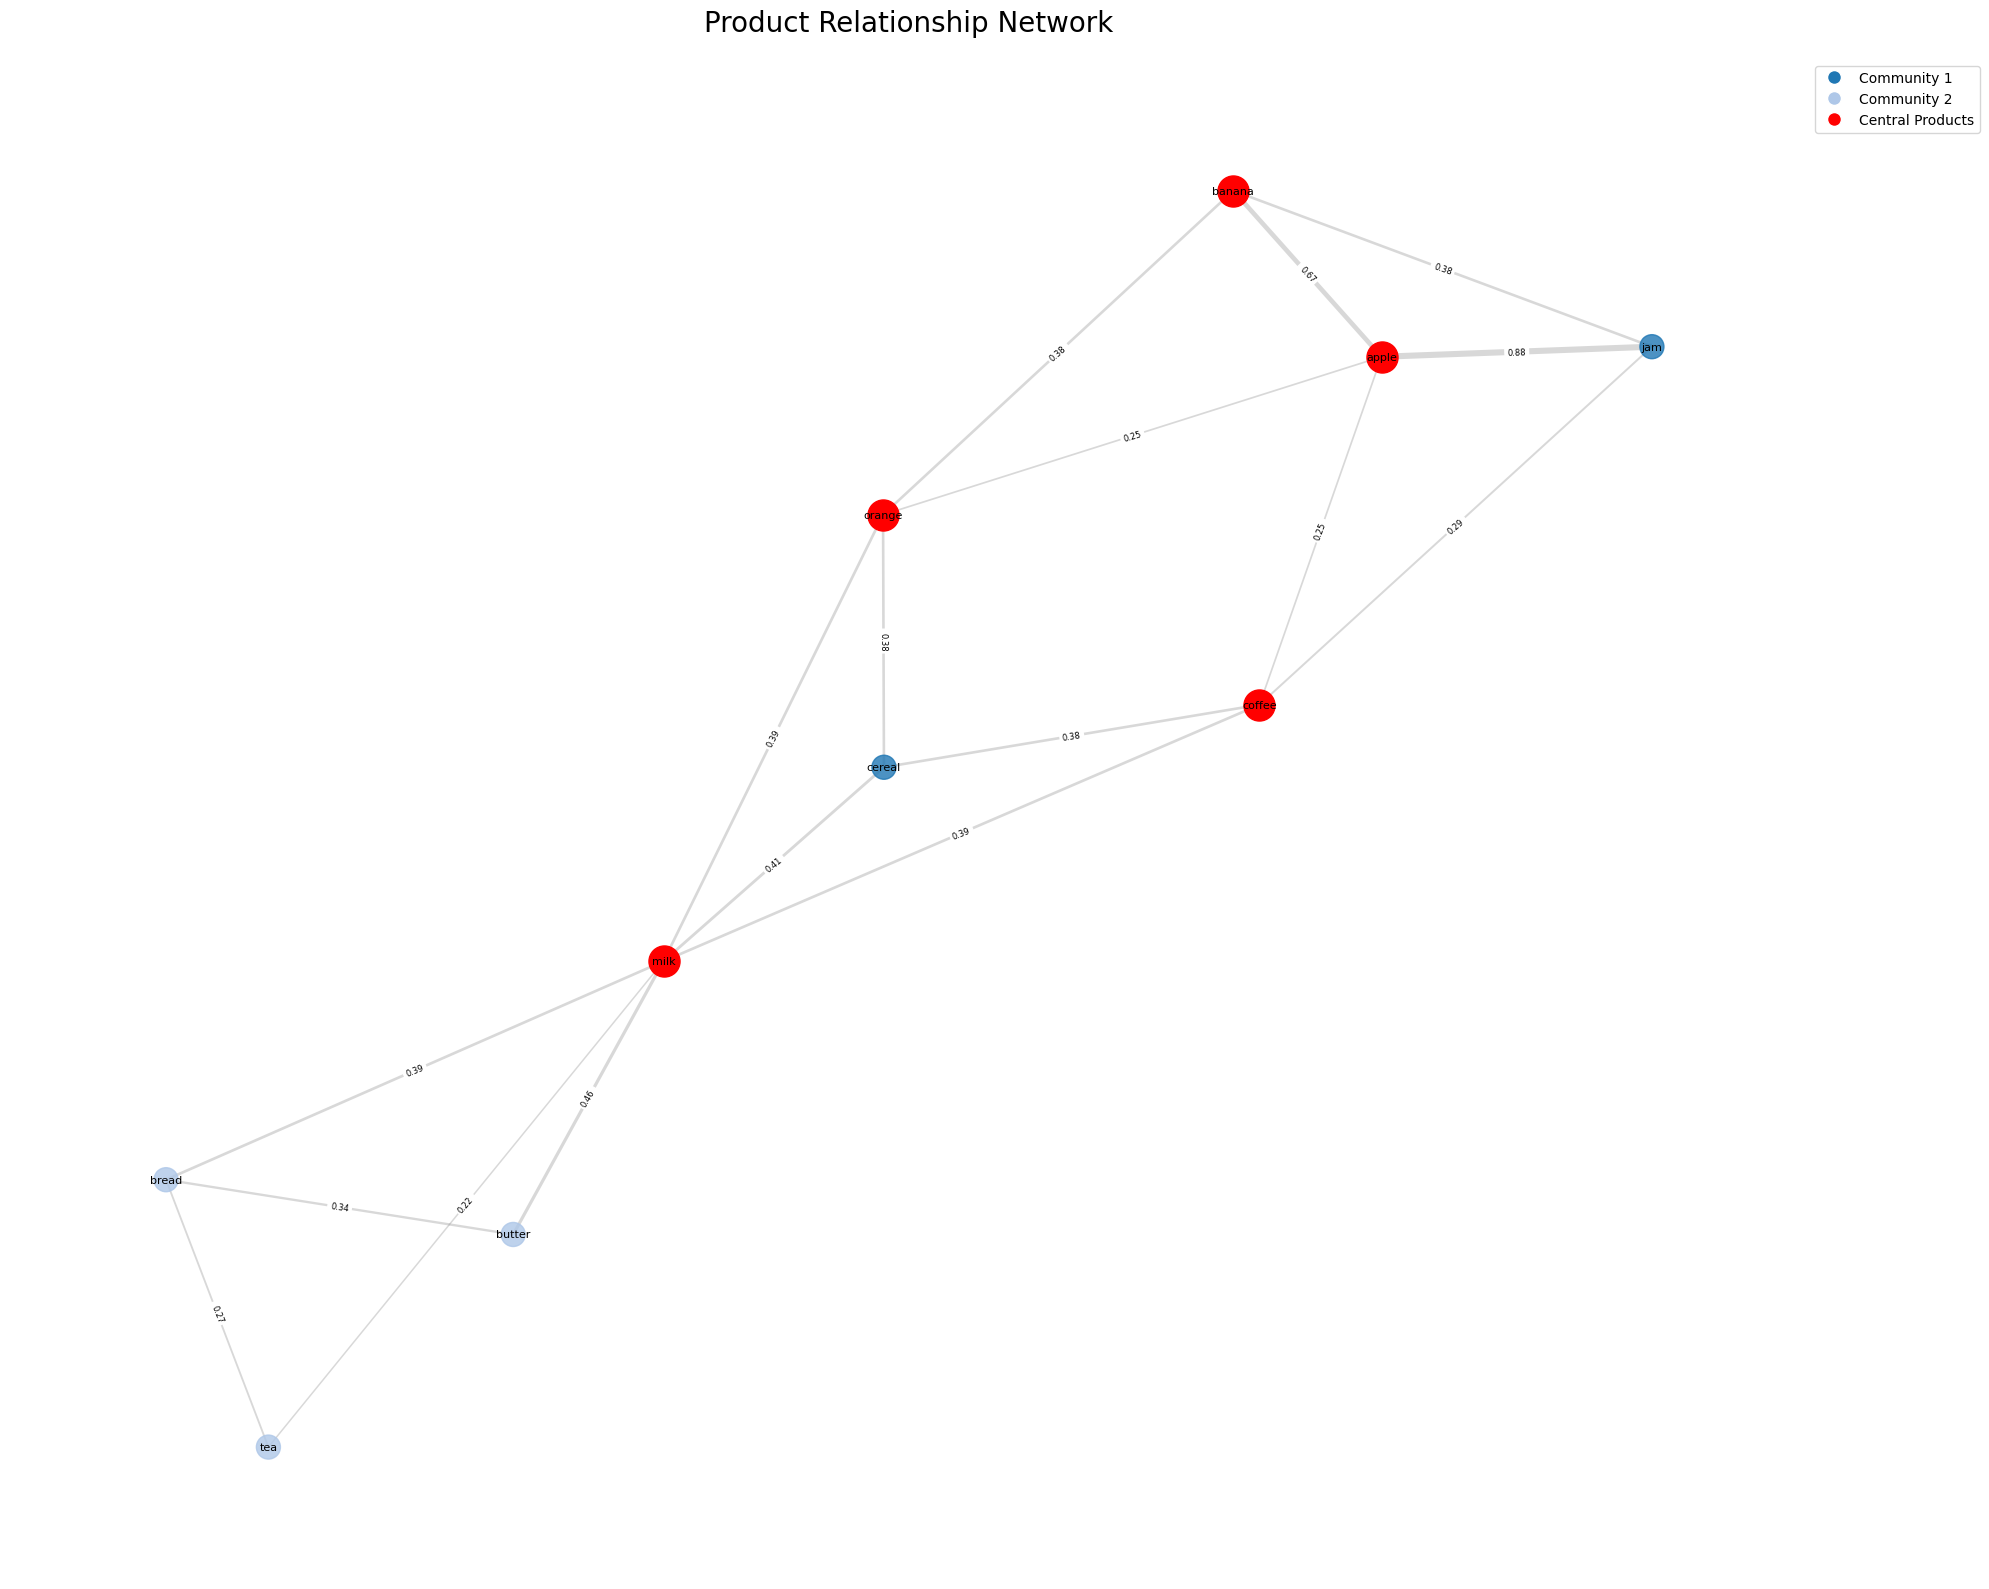

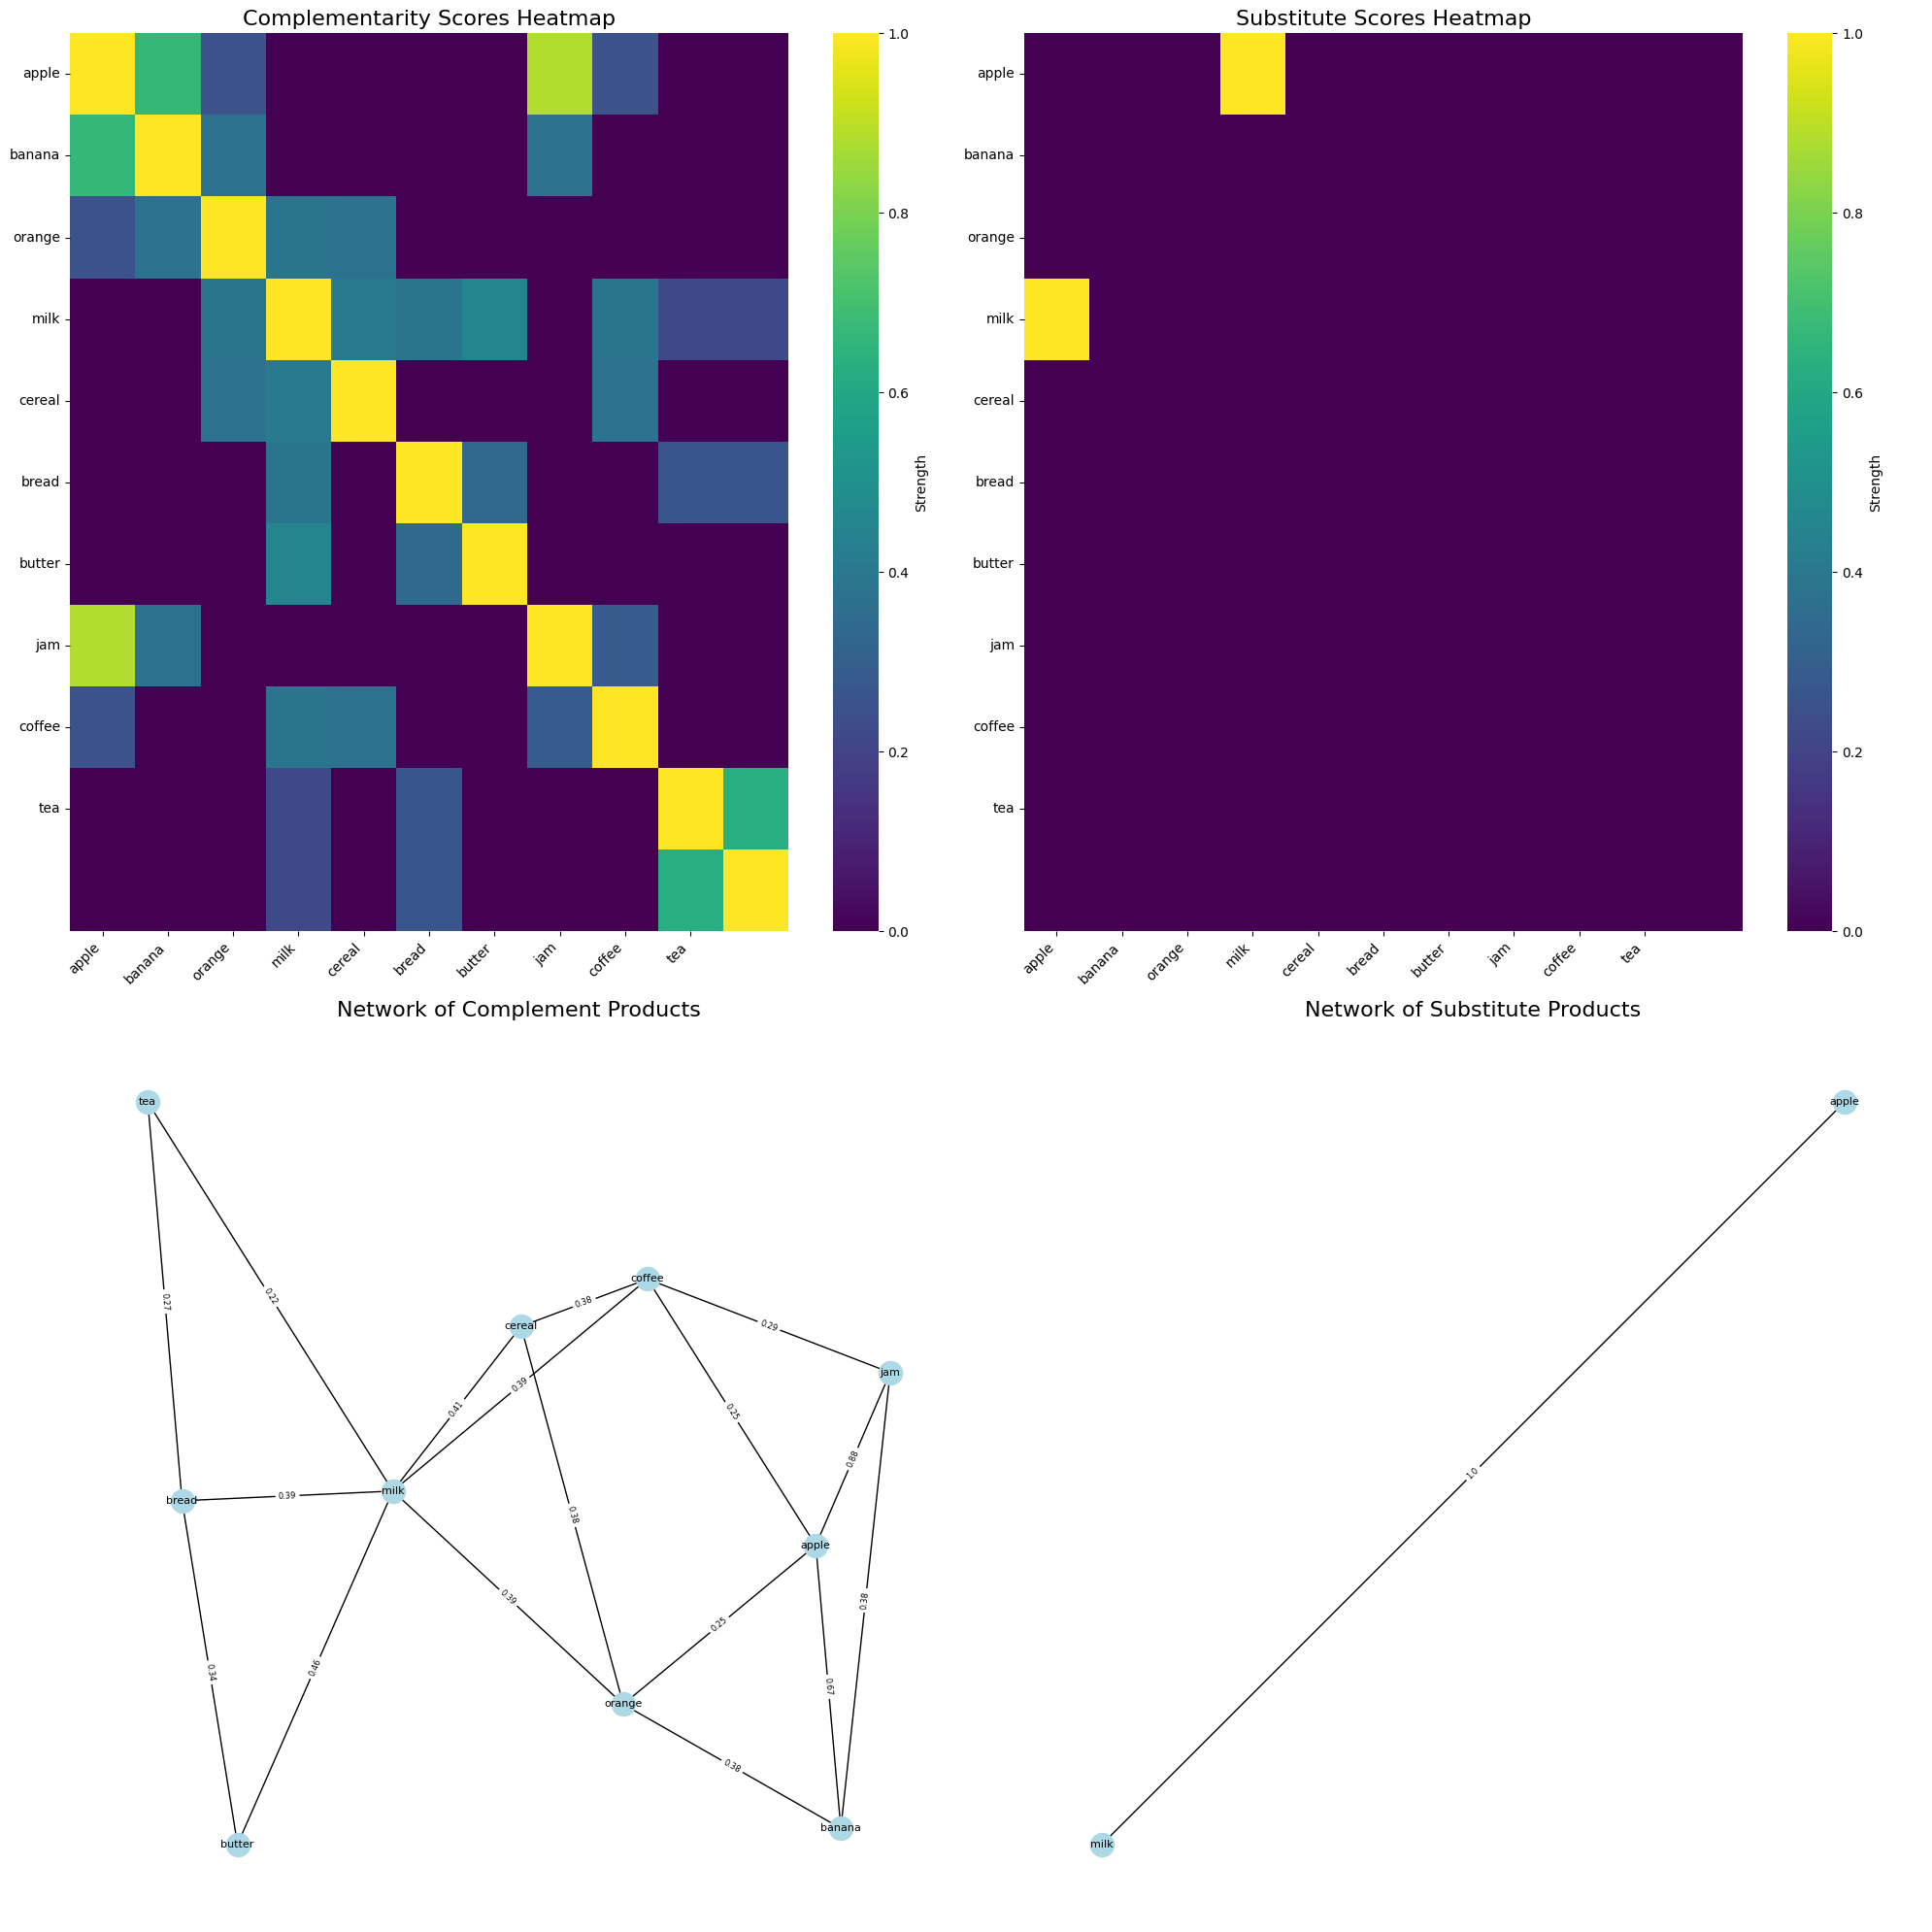


Product Communities:
Community 1: apple, jam, banana, orange, coffee, cereal
Community 2: tea, milk, butter, bread

Central Products:
milk, apple, orange, coffee, banana

Top 5 Strongest Complementary Relationships:
apple - jam: 0.88
apple - banana: 0.67
milk - butter: 0.46
milk - cereal: 0.41
orange - milk: 0.39

Top 5 Strongest Substitute Relationships:
apple - milk: 1.00


In [17]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.sparse import csr_matrix
from community import community_louvain
import seaborn as sns
import random
#import statements 
random.seed(42)
np.random.seed(42)
#sample data by myself
def create_sample_data():
    products = ['apple', 'banana', 'orange', 'milk', 'cereal', 'bread', 'butter', 'jam', 'coffee', 'tea']
    
    transactions = [
        ['apple', 'banana', 'orange'],
        ['milk', 'cereal'],
        ['bread', 'butter', 'jam'],
        ['coffee', 'milk'],
        ['tea', 'milk'],
        ['apple', 'orange'],
        ['bread', 'jam'],
        ['cereal', 'milk', 'banana'],
        ['coffee', 'bread', 'butter'],
        ['tea', 'bread', 'jam'],
        ['apple', 'milk'],
        ['orange', 'milk'],
        ['banana', 'milk'],
        ['coffee', 'milk', 'sugar'],
        ['tea', 'milk', 'sugar'],
    ]
    
    # Shuffle the transactions list
    random.shuffle(transactions)
    
    # Shuffle items within each transaction
    for transaction in transactions:
        random.shuffle(transaction) 
    
    return products, transactions

def create_bipartite_network(transactions):
    B = nx.Graph()
    for i, transaction in enumerate(transactions):
        B.add_nodes_from([f't{i}'], bipartite=0)
        B.add_nodes_from(transaction, bipartite=1)
        B.add_edges_from([(f't{i}', product) for product in transaction])
    return B

def er_null_model(B, alpha_m, alpha_l):
    products = [n for n, d in B.nodes(data=True) if d['bipartite']==1]
    nt = len([n for n, d in B.nodes(data=True) if d['bipartite']==0])
    
    A_m = np.zeros((len(products), len(products)))
    A_l = np.zeros((len(products), len(products)))
    
    for i, prod1 in enumerate(products):
        for j, prod2 in enumerate(products):
            if i != j:
                pi = B.degree(prod1) / nt
                pj = B.degree(prod2) / nt
                mu = nt * pi * pj
                sigma = np.sqrt(nt * pi * pj * (1 - pi * pj)) #central limit theorem approximation
                cn = len(list(nx.common_neighbors(B, prod1, prod2))) #no. of common neighbours
                
                if cn > mu + norm.ppf(1-alpha_m) * sigma: #check if more
                    A_m[i,j] = 1
                if cn < mu - norm.ppf(1-alpha_l) * sigma: #check if less
                    A_l[i,j] = 1
    
    return A_m, A_l

def original_measure(B):
    products = [n for n, d in B.nodes(data=True) if d['bipartite']==1]
    transactions = [n for n, d in B.nodes(data=True) if d['bipartite']==0]
    
    sim = np.zeros((len(products), len(products)))
    
    for i, prod1 in enumerate(products):
        for j, prod2 in enumerate(products):
            numerator = sum([1/(B.degree(t)) for t in nx.common_neighbors(B, prod1, prod2)])
            denominator = np.sqrt(sum([1/(B.degree(t)) for t in B.neighbors(prod1)]) * 
                                  sum([1/(B.degree(t)) for t in B.neighbors(prod2)]))
            sim[i,j] = numerator / denominator if denominator != 0 else 0
    
    return sim

def extract_roles(W):
    G = nx.from_numpy_array(W)
    partition = community_louvain.best_partition(G)
    return partition

def create_weighted_graph(matrix, products, threshold=0):
    G = nx.Graph()
    for i, prod1 in enumerate(products):
        for j, prod2 in enumerate(products):
            if i != j and matrix[i,j] > threshold:
                G.add_edge(prod1, prod2, weight=round(matrix[i,j], 2))
    return G

def visualize_product_network(G, communities, central_products):
    plt.figure(figsize=(20, 16))
    
    pos = nx.spring_layout(G, k=0.5, iterations=50)
    
    color_map = plt.cm.get_cmap('tab20')
    colors = [color_map(i) for i in range(len(communities))]
    
    # Draw edges with varying thickness based on weight
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
    nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color='gray', width=[w * 5 for w in edge_weights])
    
    # Draw nodes for each community
    for i, community in enumerate(communities):
        nx.draw_networkx_nodes(G, pos, 
                               nodelist=list(community),
                               node_color=[colors[i]]*len(community),
                               node_size=300,
                               alpha=0.8)
    
    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=8)
    
    # Highlight central products
    nx.draw_networkx_nodes(G, pos,
                           nodelist=central_products,
                           node_color='red',
                           node_size=500)
    
    # Add edge labels for weights
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)
    
    plt.title("Product Relationship Network", fontsize=20, pad=20)
    plt.axis('off')
    
    # Add legend for communities
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=f'Community {i+1}',
                                  markerfacecolor=colors[i], markersize=10)
                       for i in range(len(communities))]
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label='Central Products',
                                      markerfacecolor='red', markersize=10))
    plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))
    
    plt.tight_layout()
    plt.show
    

def plot_heatmap(matrix, products, title, ax):
    sns.heatmap(matrix, xticklabels=products, yticklabels=products, 
                cmap='viridis', ax=ax, cbar_kws={'label': 'Strength'})
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

def plot_network(G, title, ax):
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=300, font_size=8, ax=ax)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6, ax=ax)
    ax.set_title(title, fontsize=16)
    ax.axis('off')

def main():
    products, transactions = create_sample_data()
    
    B = create_bipartite_network(transactions)
    
    A_m, A_l = er_null_model(B, 0.05, 0.05)
    
    W_c = original_measure(B)
    
    complement_roles = extract_roles(W_c)
    
    G_complement = create_weighted_graph(W_c, products, threshold=0.1)
    G_substitute = create_weighted_graph(A_l, products)
    
    communities = list(nx.community.greedy_modularity_communities(G_complement))
    central_products = sorted(nx.degree_centrality(G_complement), key=nx.degree_centrality(G_complement).get, reverse=True)[:5]
    
    # Main network visualization
    visualize_product_network(G_complement, communities, central_products)
    
    # Additional visualizations
    fig, axs = plt.subplots(2, 2, figsize=(20, 20))
    
    plot_heatmap(W_c, products, 'Complementarity Scores Heatmap', axs[0, 0])
    plot_heatmap(A_l, products, 'Substitute Scores Heatmap', axs[0, 1])
    plot_network(G_complement, 'Network of Complement Products', axs[1, 0])
    plot_network(G_substitute, 'Network of Substitute Products', axs[1, 1])
    
    plt.tight_layout()
    plt.show()

    # Print additional information
    print("\nProduct Communities:")
    for i, community in enumerate(communities):
        print(f"Community {i+1}: {', '.join(community)}")
    
    print("\nCentral Products:")
    print(', '.join(central_products))
    
    print("\nTop 5 Strongest Complementary Relationships:")
    complementary_strengths = [(p1, p2, W_c[i, j]) for i, p1 in enumerate(products) for j, p2 in enumerate(products) if i < j]
    for p1, p2, strength in sorted(complementary_strengths, key=lambda x: x[2], reverse=True)[:5]:
        print(f"{p1} - {p2}: {strength:.2f}")
    
    print("\nTop 5 Strongest Substitute Relationships:")
    substitute_strengths = [(p1, p2, A_l[i, j]) for i, p1 in enumerate(products) for j, p2 in enumerate(products) if i < j and A_l[i, j] > 0]
    for p1, p2, strength in sorted(substitute_strengths, key=lambda x: x[2], reverse=True)[:5]:
        print(f"{p1} - {p2}: {strength:.2f}")

if __name__ == "__main__":
    main()



Analyzing Complement Role 1


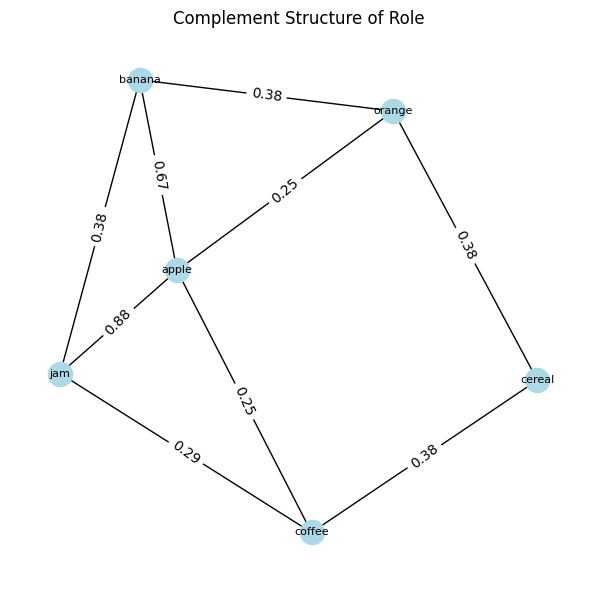

Role analysis:
Number of products: 6
Complement density: 0.60
Substitute density: 0.40
Products: apple, jam, banana, orange, coffee, cereal

Analyzing Complement Role 2


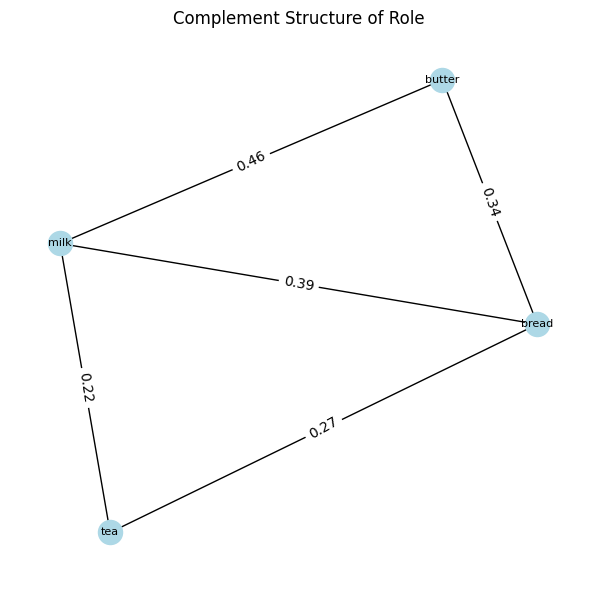

Role analysis:
Number of products: 4
Complement density: 0.83
Substitute density: 0.33
Products: tea, milk, butter, bread


In [36]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import norm
from community import community_louvain
import seaborn as sns
import random
from sklearn.metrics import normalized_mutual_info_score
random.seed(42)
np.random.seed(42)
def create_sample_data():
    products = ['apple', 'banana', 'orange', 'milk', 'cereal', 'bread', 'butter', 'jam', 'coffee', 'tea']
    
    transactions = [
        ['apple', 'banana', 'orange'],
        ['milk', 'cereal'],
        ['bread', 'butter', 'jam'],
        ['coffee', 'milk'],
        ['tea', 'milk'],
        ['apple', 'orange'],
        ['bread', 'jam'],
        ['cereal', 'milk', 'banana'],
        ['coffee', 'bread', 'butter'],
        ['tea', 'bread', 'jam'],
        ['apple', 'milk'],
        ['orange', 'milk'],
        ['banana', 'milk'],
        ['coffee', 'milk', 'sugar'],
        ['tea', 'milk', 'sugar'],
    ]
    
    # Shuffle the transactions list
    random.shuffle(transactions)
    
    # Shuffle items within each transaction
    for transaction in transactions:
        random.shuffle(transaction) 
    
    return products, transactions
def create_bipartite_network(transactions):
    B = nx.Graph()
    for i, transaction in enumerate(transactions):
        B.add_nodes_from([f't{i}'], bipartite=0)
        B.add_nodes_from(transaction, bipartite=1)
        B.add_edges_from([(f't{i}', product) for product in transaction])
    return B

def er_null_model(B, alpha_m, alpha_l):
    products = [n for n, d in B.nodes(data=True) if d['bipartite']==1]
    nt = len([n for n, d in B.nodes(data=True) if d['bipartite']==0])
    
    A_m = np.zeros((len(products), len(products)))
    A_l = np.zeros((len(products), len(products)))
    
    for i, prod1 in enumerate(products):
        for j, prod2 in enumerate(products):
            if i != j:
                pi = B.degree(prod1) / nt
                pj = B.degree(prod2) / nt
                mu = nt * pi * pj
                sigma = np.sqrt(nt * pi * pj * (1 - pi * pj))
                cn = len(list(nx.common_neighbors(B, prod1, prod2)))
                
                if cn > mu + norm.ppf(1-alpha_m) * sigma:
                    A_m[i,j] = 1
                if cn < mu:  # Changed this condition to make it easier to identify substitutes
                    A_l[i,j] = 1
    
    return A_m, A_l

def original_measure(B):
    products = [n for n, d in B.nodes(data=True) if d['bipartite']==1]
    transactions = [n for n, d in B.nodes(data=True) if d['bipartite']==0]
    
    sim = np.zeros((len(products), len(products)))
    
    for i, prod1 in enumerate(products):
        for j, prod2 in enumerate(products):
            numerator = sum([1/(B.degree(t)) for t in nx.common_neighbors(B, prod1, prod2)])
            denominator = np.sqrt(sum([1/(B.degree(t)) for t in B.neighbors(prod1)]) * 
                                  sum([1/(B.degree(t)) for t in B.neighbors(prod2)]))
            sim[i,j] = numerator / denominator if denominator != 0 else 0
    
    return sim

def calculate_substitutability_scores(B, A_l):
    products = [n for n, d in B.nodes(data=True) if d['bipartite']==1]
    W_s = np.zeros((len(products), len(products)))
    
    for i, prod1 in enumerate(products):
        for j, prod2 in enumerate(products):
            if A_l[i, j] == 1:
                # Calculate Jaccard similarity
                neighbors1 = set(B.neighbors(prod1))
                neighbors2 = set(B.neighbors(prod2))
                jaccard = len(neighbors1.intersection(neighbors2)) / len(neighbors1.union(neighbors2))
                W_s[i,j] = 1 - jaccard  # Higher score for less similar products
    
    return W_s

def extract_roles(W_c, W_s):
    G_c = nx.from_numpy_array(W_c)
    G_s = nx.from_numpy_array(W_s)
    
    partition_c = community_louvain.best_partition(G_c)
    partition_s = community_louvain.best_partition(G_s)
    
    return partition_c, partition_s

def calculate_nmi(partition_c, partition_s):
    labels_c = list(partition_c.values())
    labels_s = list(partition_s.values())
    return normalized_mutual_info_score(labels_c, labels_s)

def create_weighted_graph(matrix, products, threshold=0):
    G = nx.Graph()
    for i, prod1 in enumerate(products):
        for j, prod2 in enumerate(products):
            if i != j and matrix[i,j] > threshold:
                G.add_edge(prod1, prod2, weight=round(matrix[i,j], 2))
    return G

def visualize_product_network(G_c, G_s, communities_c, communities_s, central_products):
    plt.figure(figsize=(20, 16))
    
    pos = nx.spring_layout(G_c, k=0.5, iterations=50)
    
    color_map = plt.cm.get_cmap('tab20')
    colors_c = [color_map(i) for i in range(len(communities_c))]
    colors_s = [color_map(i + len(communities_c)) for i in range(len(communities_s))]
    
    nx.draw_networkx_edges(G_c, pos, alpha=0.3, edge_color='blue', width=[G_c[u][v]['weight'] * 5 for u, v in G_c.edges()])
    nx.draw_networkx_edges(G_s, pos, alpha=0.3, edge_color='red', width=[G_s[u][v]['weight'] * 5 for u, v in G_s.edges()])
    
    for i, community in enumerate(communities_c):
        nx.draw_networkx_nodes(G_c, pos, 
                               nodelist=list(community),
                               node_color=[colors_c[i]]*len(community),
                               node_size=300,
                               alpha=0.8)
    
    for i, community in enumerate(communities_s):
        nx.draw_networkx_nodes(G_s, pos, 
                               nodelist=list(community),
                               node_color=[colors_s[i]]*len(community),
                               node_size=200,
                               alpha=0.5)
    
    nx.draw_networkx_labels(G_c, pos, font_size=8)
    
    nx.draw_networkx_nodes(G_c, pos,
                           nodelist=central_products,
                           node_color='yellow',
                           node_size=500)
    
    plt.title("Product Relationship Network", fontsize=20, pad=20)
    plt.axis('off')
    
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=f'Complement Community {i+1}',
                                  markerfacecolor=colors_c[i], markersize=10)
                       for i in range(len(communities_c))]
    legend_elements += [plt.Line2D([0], [0], marker='o', color='w', label=f'Substitute Community {i+1}',
                                   markerfacecolor=colors_s[i], markersize=10)
                        for i in range(len(communities_s))]
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label='Central Products',
                                      markerfacecolor='yellow', markersize=10))
    legend_elements.append(plt.Line2D([0], [0], color='blue', lw=2, label='Complement'))
    legend_elements.append(plt.Line2D([0], [0], color='red', lw=2, label='Substitute'))
    plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))
    
    plt.tight_layout()
    plt.show()

def analyze_role_structure(G_c, G_s, role, products):
    subgraph_c = G_c.subgraph(role)
    subgraph_s = G_s.subgraph(role)
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(121)
    pos = nx.spring_layout(subgraph_c)
    nx.draw(subgraph_c, pos, with_labels=True, node_color='lightblue', node_size=300, font_size=8)
    nx.draw_networkx_edge_labels(subgraph_c, pos, edge_labels={(u,v): f"{d['weight']:.2f}" for u,v,d in subgraph_c.edges(data=True)})
    plt.title(f"Complement Structure of Role")
    

    
    plt.tight_layout()
    plt.show()
    
    print(f"Role analysis:")
    print(f"Number of products: {len(role)}")
    print(f"Complement density: {nx.density(subgraph_c):.2f}")
    print(f"Substitute density: {nx.density(subgraph_s):.2f}")
    print(f"Products: {', '.join(role)}")

def plot_heatmap(matrix, products, title, ax):
    sns.heatmap(matrix, xticklabels=products, yticklabels=products, 
                cmap='viridis', ax=ax, cbar_kws={'label': 'Strength'})
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

def get_top_relationships(matrix, products, top_n=5):
    # Extract top N strongest relationships from the matrix
    relationships = [(products[i], products[j], matrix[i, j]) 
                     for i in range(len(products)) for j in range(len(products)) if i < j and matrix[i, j] > 0]
    return sorted(relationships, key=lambda x: x[2], reverse=True)[:top_n]

def main():
    products, transactions = create_sample_data()
    
    B = create_bipartite_network(transactions)
    
    A_m, A_l = er_null_model(B, 0.05, 0.05)
    
    W_c = original_measure(B)
    W_s = calculate_substitutability_scores(B, A_l)
    
    complement_roles, substitute_roles = extract_roles(W_c, W_s)
    
    nmi = calculate_nmi(complement_roles, substitute_roles)
    
    G_complement = create_weighted_graph(W_c, products, threshold=0.1)
    G_substitute = create_weighted_graph(W_s, products, threshold=0.1)
    
    communities_c = list(nx.community.greedy_modularity_communities(G_complement)) if G_complement.number_of_edges() > 0 else []
    communities_s = list(nx.community.greedy_modularity_communities(G_substitute)) if G_substitute.number_of_edges() > 0 else []
    central_products = sorted(nx.degree_centrality(G_complement), key=nx.degree_centrality(G_complement).get, reverse=True)[:5]
    


    for i, role in enumerate(communities_c):
        print(f"\nAnalyzing Complement Role {i+1}")
        analyze_role_structure(G_complement, G_substitute, role, products)


if __name__ == "__main__":
    main()
